### Imports & Logging Setup

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import logging

# Machine Learning
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer

# Suppress warnings
warnings.simplefilter("ignore")

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features

In [2]:
import pandas as pd
import os
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File paths
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "chi_squared": "../results/chi_squared_features.csv",
    "information_gain": "../results/information_gain_results.csv",
    "lasso": "../results/lasso_results.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load features safely
def load_all_features(file_paths, num_features=10):
    feature_sets = {}

    for key, path in file_paths.items():
        if key == "processed_data":
            continue  # Skip processed data file

        if os.path.exists(path):
            df = pd.read_csv(path)
            if key == "fold_change" and "log2_fold_change" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "log2_fold_change")["Unnamed: 0"])
            elif key == "chi_squared" and "Score" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Score")["Feature"])
            elif key == "information_gain" and "Info_Gain_General" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Info_Gain_General")["Feature"])
            elif key == "lasso" and "Coefficient" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Coefficient")["Feature"])
            else:
                logging.warning(f"Unexpected format in {key}, skipping.")
        else:
            logging.warning(f"Feature selection file missing: {path}")

    # Merge selected features (remove duplicates)
    combined_features = set().union(*feature_sets.values())
    logging.info(f"Total unique features selected: {len(combined_features)}")

    return list(combined_features)

# Load processed data
if os.path.exists(file_paths["processed_data"]):
    processed_data = pd.read_csv(file_paths["processed_data"])
else:
    raise FileNotFoundError(f"Processed data file missing: {file_paths['processed_data']}")

# Create a binary diagnosis column
processed_data["diagnosis"] = processed_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Select top features
num_features_to_select = 10
top_features = load_all_features(file_paths, num_features=num_features_to_select)

# Define target columns
target_column_diagnosis = "diagnosis"
target_column_stage = "stage"
target_column_subtype = "subtype"

2025-02-26 16:10:03,077 - INFO - Total unique features selected: 38


### Process Features & Labels for Multi-Output Classification

In [3]:
def process_features_and_labels(processed_data, selected_features):
    """
    Filters processed data for selected features and extracts multi-output target labels.
    
    Args:
        processed_data (pd.DataFrame): Data containing features and target variables.
        selected_features (list): List of feature names to filter.

    Returns:
        tuple: Processed feature dataframe (X) and label dataframe (y).
    """
    # Check for missing features
    missing_features = [f for f in selected_features if f not in processed_data.columns]
    if missing_features:
        logging.warning(f"{len(missing_features)} features missing from dataset! Missing: {missing_features}")

    # Stop if more than 50% of features are missing
    missing_ratio = len(missing_features) / len(selected_features)
    if missing_ratio > 0.5:
        raise ValueError(f"More than 50% of selected features are missing! ({missing_ratio * 100:.2f}%)")

    # Keep only available features
    selected_features = [f for f in selected_features if f in processed_data.columns]

    # Extract features and ensure numeric values
    X = processed_data[selected_features].apply(pd.to_numeric, errors='coerce')

    # Extract labels
    y = processed_data[["diagnosis", "stage", "subtype"]]

    # Check for missing values
    if X.isnull().values.any() or y.isnull().values.any():
        logging.warning("Missing values detected in features or labels.")

        # Print summary of missing values
        print("\n Missing values per feature (Top 5):")
        missing_counts = X.isnull().sum()
        print(missing_counts[missing_counts > 0].head())

        print("\n Missing values in labels:")
        print(y.isnull().sum())

        # Drop rows with missing values
        valid_indices = ~(X.isnull().any(axis=1) | y.isnull().any(axis=1))
        X = X[valid_indices]
        y = y[valid_indices]

    # Standardize feature values
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    logging.info("Features have been standardized.")

    # Train-Test Split (No SMOTE, just stratified sampling)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y["diagnosis"])

    # Log dataset details
    logging.info(f"Training Set Shape: {X_train.shape}")
    logging.info(f"Test Set Shape: {X_test.shape}")
    logging.info(f"Class distribution in training set:\n{y_train['diagnosis'].value_counts(normalize=True)}")

    return X_train, X_test, y_train, y_test

# Process features and labels
X_train, X_test, y_train, y_test = process_features_and_labels(processed_data, top_features)

# Debugging: Check the prepared data
print("\nExpression values sample:")
print(X_train.head())

print("\nFeature statistics:")
print(X_train.describe())

print("\nClass proportions in train set:")
print(y_train["diagnosis"].value_counts(normalize=True))

2025-02-26 16:10:06,956 - INFO - Features have been standardized.
2025-02-26 16:10:06,960 - INFO - Training Set Shape: (872, 38)
2025-02-26 16:10:06,961 - INFO - Test Set Shape: (219, 38)
2025-02-26 16:10:06,964 - INFO - Class distribution in training set:
diagnosis
1    0.989679
0    0.010321
Name: proportion, dtype: float64



Expression values sample:
     hsa-mir-185  hsa-mir-571  hsa-mir-631  hsa-mir-5690  hsa-mir-526a-2  \
459    -1.140265    -0.059853    -0.126904      0.614769       -0.040323   
765    -0.064177    -0.059853    -0.126904     -0.706293       -0.040323   
749     3.249506    -0.059853    -0.126904      3.280114       -0.040323   
990    -0.413189    -0.059853    -0.126904     -0.706293       -0.040323   
270    -0.099586    -0.059853    -0.126904     -0.429187       -0.040323   

     hsa-mir-4300  hsa-mir-1283-2  hsa-mir-520h  hsa-mir-509-1   subtype  ...  \
459     -0.042693       -0.067550     -0.068348      -0.228815 -0.893706  ...   
765     -0.042693       -0.055086     -0.068348      -0.240134  1.014383  ...   
749     -0.042693       -0.067550     -0.029936       0.834090  1.014383  ...   
990     -0.042693       -0.067550     -0.068348       0.835619  1.014383  ...   
270     -0.042693       -0.048564     -0.060338      -0.227362 -0.893706  ...   

     hsa-mir-518f  hsa-mir-76

### Train-Test Split & Feature Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# We already have our data split and processed from the previous block:
# X_train, X_test, y_train, y_test = process_features_and_labels(processed_data, top_features)

# Extract labels for each target variable
y_train_diagnosis = y_train["diagnosis"]
y_test_diagnosis = y_test["diagnosis"]
y_train_stage = y_train["stage"]
y_test_stage = y_test["stage"]
y_train_subtype = y_train["subtype"]
y_test_subtype = y_test["subtype"]

# Log Split Information
print("\nTrain-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

# Print distributions for each target variable
print("\nTraining set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts(normalize=True))

print("\nTraining set class distribution (Stage):")
print(y_train_stage.value_counts(normalize=True))

print("\nTraining set class distribution (Subtype):")
print(y_train_subtype.value_counts(normalize=True))

print("\nTesting set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts(normalize=True))

print("\nTesting set class distribution (Stage):")
print(y_test_stage.value_counts(normalize=True))

print("\nTesting set class distribution (Subtype):")
print(y_test_subtype.value_counts(normalize=True))


Train-Test Split Information:
Training set: (872, 38), Testing set: (219, 38)

Training set class distribution (Diagnosis):
diagnosis
1    0.989679
0    0.010321
Name: proportion, dtype: float64

Training set class distribution (Stage):
stage
1    0.528670
2    0.274083
3    0.160550
4    0.026376
0    0.010321
Name: proportion, dtype: float64

Training set class distribution (Subtype):
subtype
1    0.510321
2    0.478211
0    0.010321
4    0.001147
Name: proportion, dtype: float64

Testing set class distribution (Diagnosis):
diagnosis
1    0.990868
0    0.009132
Name: proportion, dtype: float64

Testing set class distribution (Stage):
stage
1    0.479452
2    0.315068
3    0.159817
4    0.036530
0    0.009132
Name: proportion, dtype: float64

Testing set class distribution (Subtype):
subtype
1    0.525114
2    0.465753
0    0.009132
Name: proportion, dtype: float64


### Train Multi-Output SVM Model

In [5]:
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Suppress warnings
warnings.simplefilter("ignore")

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Train SVM Models for Diagnosis, Stage, and Subtype
models = {}
best_estimators = {}
y_preds = {}

for label, y_train, y_test in zip(
    ["Diagnosis", "Stage", "Subtype"],
    [y_train_diagnosis, y_train_stage, y_train_subtype],
    [y_test_diagnosis, y_test_stage, y_test_subtype]
):
    print(f"\nTraining {label} SVM...")
    
    # Define & train model with GridSearchCV
    svm = SVC(class_weight="balanced", random_state=42)
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Store best model & predictions
    best_estimators[label] = grid_search.best_estimator_
    y_preds[label] = best_estimators[label].predict(X_test)

    # Print best hyperparameters & classification report
    print(f"\nBest SVM Hyperparameters ({label}): {grid_search.best_params_}")
    print(f"\nClassification Report for {label}:\n",
          classification_report(y_test, y_preds[label], zero_division=0))

# Store predictions separately
y_pred_diagnosis = y_preds["Diagnosis"]
y_pred_stage = y_preds["Stage"]
y_pred_subtype = y_preds["Subtype"]



Training Diagnosis SVM...



Best SVM Hyperparameters (Diagnosis): {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report for Diagnosis:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       217

    accuracy                           1.00       219
   macro avg       1.00      1.00      1.00       219
weighted avg       1.00      1.00      1.00       219


Training Stage SVM...

Best SVM Hyperparameters (Stage): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report for Stage:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.92      1.00      0.96       105
           2       1.00      0.94      0.97        69
           3       0.97      0.94      0.96        35
           4       1.00      0.50      0.67         8

    accuracy                           0.95       219
   macro avg       0.98      0.

### Evaluate Multi-Output Model & Feature Selection Insights


-------------------- SVM_Diagnosis Results --------------------

Accuracy: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000

Confusion Matrix:
 [[  2   0]
 [  0 217]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       217

    accuracy                           1.00       219
   macro avg       1.00      1.00      1.00       219
weighted avg       1.00      1.00      1.00       219


Confusion matrix saved to ../results/svm/svm_diagnosis_confusion_matrix.png


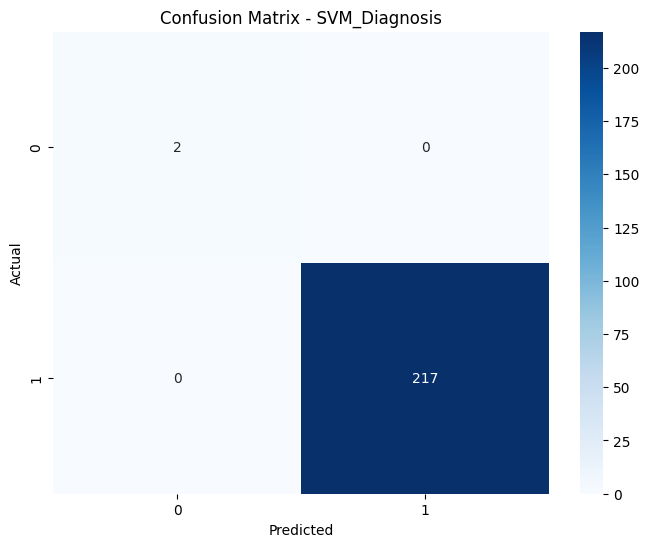

2025-02-26 16:21:27,661 - INFO - 
Model Evaluation Completed for SVM_Diagnosis!
2025-02-26 16:21:27,662 - INFO - Accuracy: 1.0000
2025-02-26 16:21:27,662 - INFO - Sensitivity: 1.0000
2025-02-26 16:21:27,663 - INFO - Specificity: 1.0000



Correlation matrix saved to ../results/svm/svm_diagnosis_correlation_matrix.png


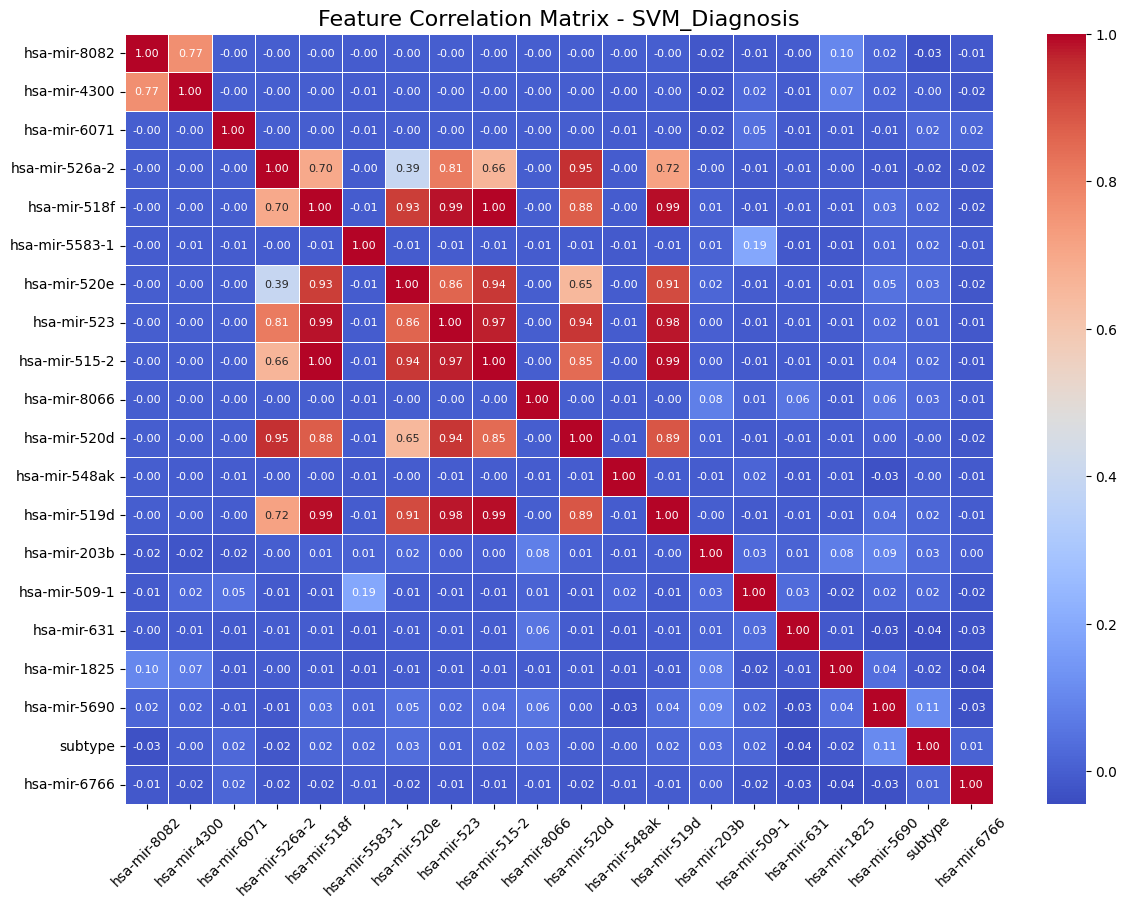


Covariance matrix saved to ../results/svm/svm_diagnosis_covariance_matrix.png


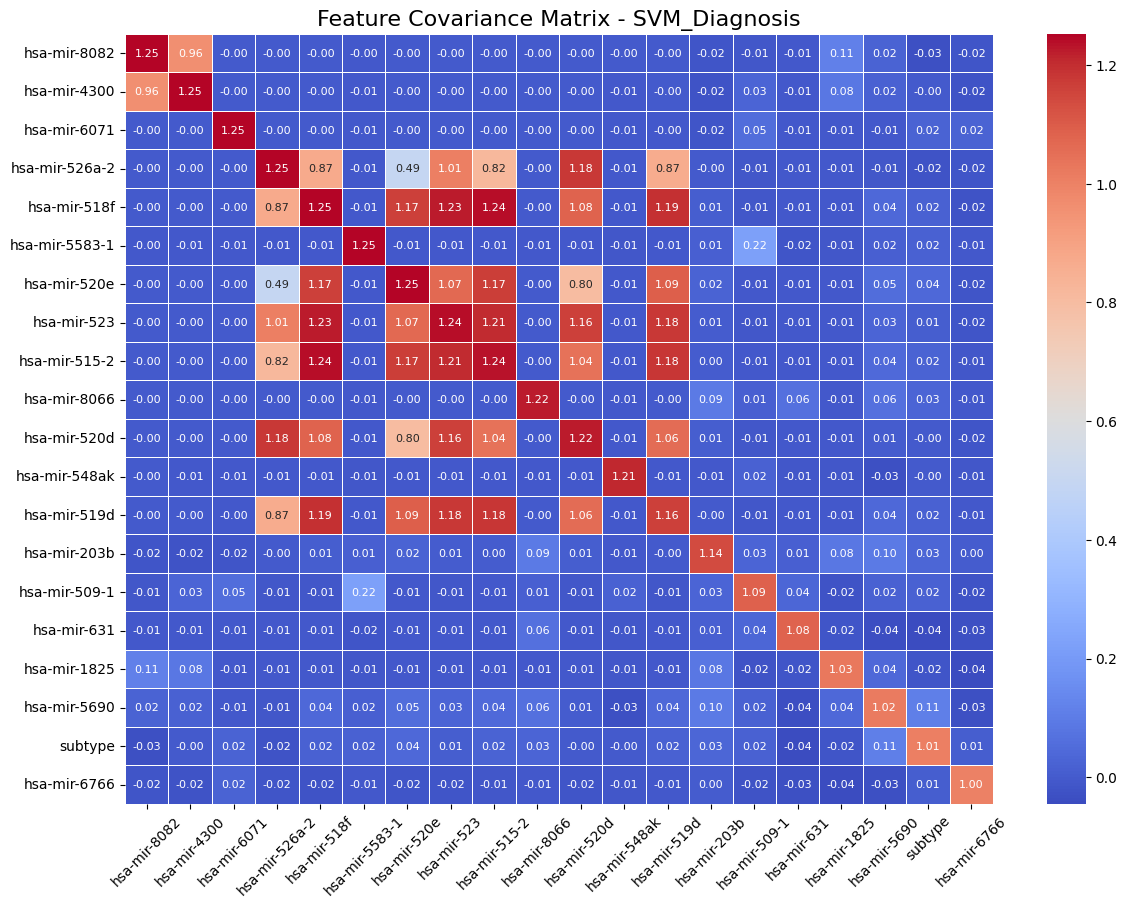


Top 10 Features Based on Maximum Variance:
['hsa-mir-8082', 'hsa-mir-4300', 'hsa-mir-6071', 'hsa-mir-526a-2', 'hsa-mir-518f', 'hsa-mir-5583-1', 'hsa-mir-520e', 'hsa-mir-523', 'hsa-mir-515-2', 'hsa-mir-8066']

Top features saved to ../results/svm/svm_diagnosis_top_features.txt

-------------------- SVM_Stage Results --------------------

Accuracy: 0.9543
Sensitivity (Recall): 0.8770
Specificity: 0.9783

Confusion Matrix:
 [[  2   0   0   0   0]
 [  0 105   0   0   0]
 [  0   4  65   0   0]
 [  0   2   0  33   0]
 [  0   3   0   1   4]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.92      1.00      0.96       105
           2       1.00      0.94      0.97        69
           3       0.97      0.94      0.96        35
           4       1.00      0.50      0.67         8

    accuracy                           0.95       219
   macro avg       0.98      0.88      0.91       219

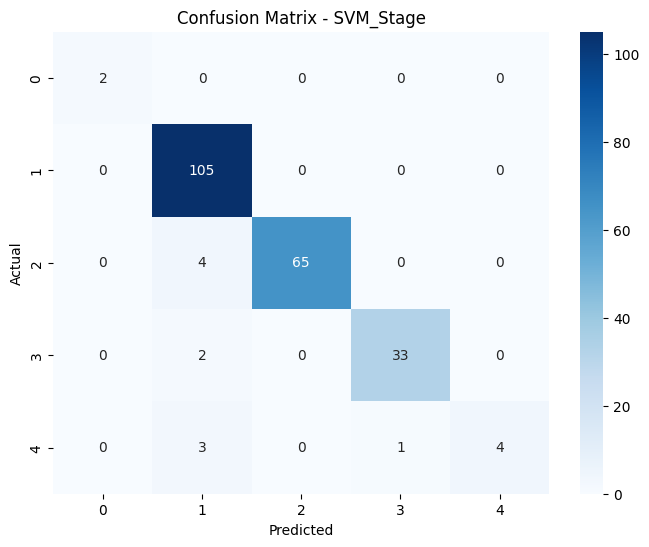

2025-02-26 16:21:30,692 - INFO - 
Model Evaluation Completed for SVM_Stage!
2025-02-26 16:21:30,692 - INFO - Accuracy: 0.9543
2025-02-26 16:21:30,693 - INFO - Sensitivity: 0.8770
2025-02-26 16:21:30,693 - INFO - Specificity: 0.9783



Correlation matrix saved to ../results/svm/svm_stage_correlation_matrix.png


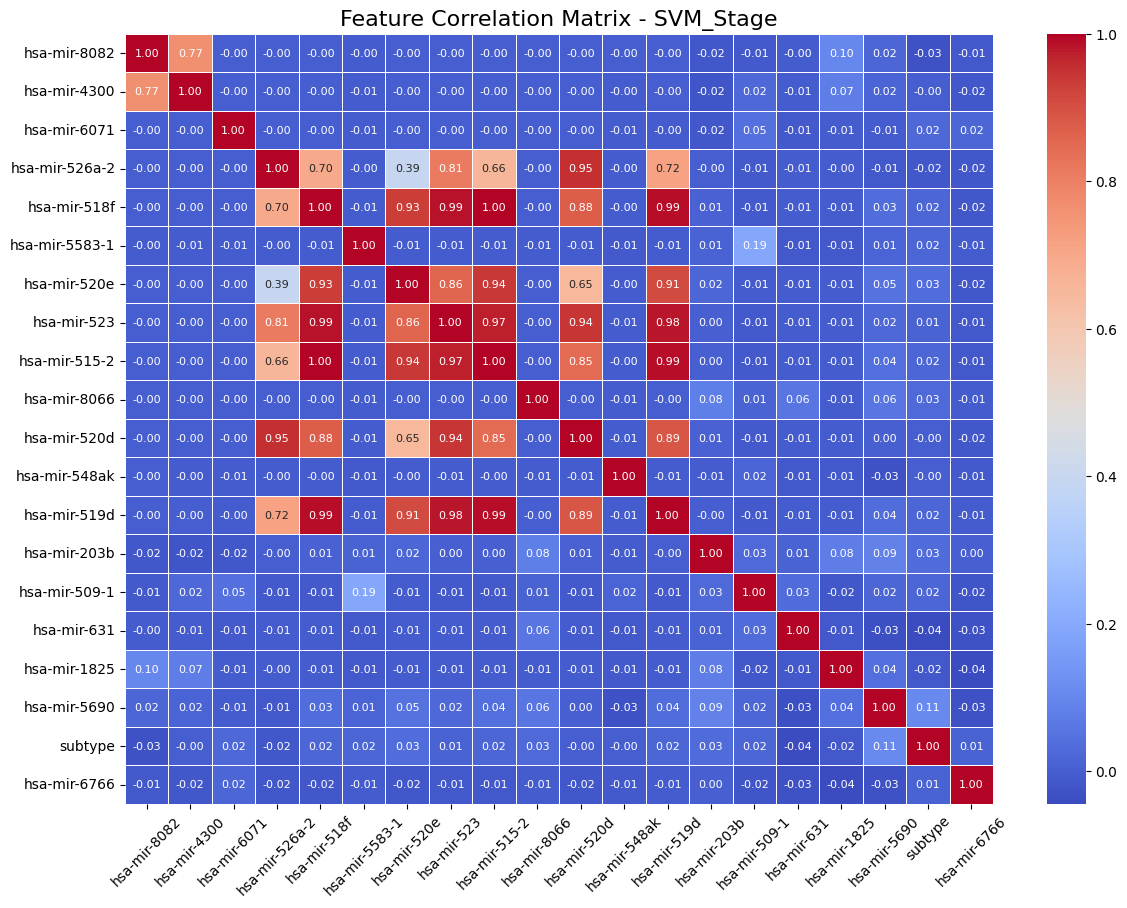


Covariance matrix saved to ../results/svm/svm_stage_covariance_matrix.png


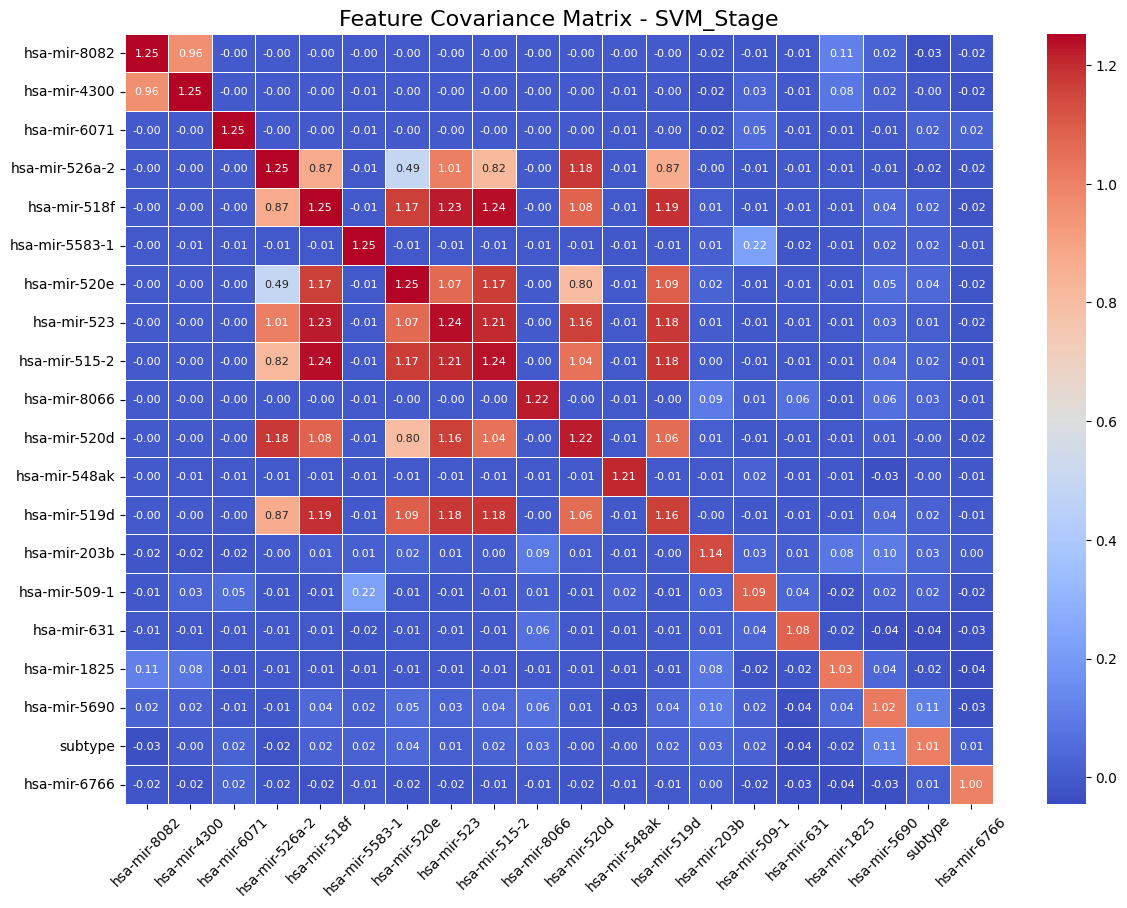


Top 10 Features Based on Maximum Variance:
['hsa-mir-8082', 'hsa-mir-4300', 'hsa-mir-6071', 'hsa-mir-526a-2', 'hsa-mir-518f', 'hsa-mir-5583-1', 'hsa-mir-520e', 'hsa-mir-523', 'hsa-mir-515-2', 'hsa-mir-8066']

Top features saved to ../results/svm/svm_stage_top_features.txt

-------------------- SVM_Subtype Results --------------------

Accuracy: 0.9680
Sensitivity (Recall): 0.9790
Specificity: 0.9782

Confusion Matrix:
 [[  2   0   0]
 [  0 110   5]
 [  0   2 100]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.98      0.96      0.97       115
           2       0.95      0.98      0.97       102

    accuracy                           0.97       219
   macro avg       0.98      0.98      0.98       219
weighted avg       0.97      0.97      0.97       219


Confusion matrix saved to ../results/svm/svm_subtype_confusion_matrix.png


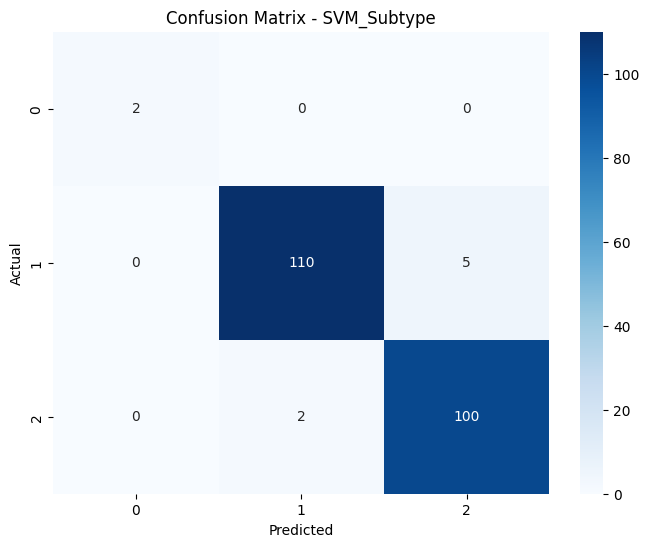

2025-02-26 16:21:33,895 - INFO - 
Model Evaluation Completed for SVM_Subtype!
2025-02-26 16:21:33,895 - INFO - Accuracy: 0.9680
2025-02-26 16:21:33,896 - INFO - Sensitivity: 0.9790
2025-02-26 16:21:33,896 - INFO - Specificity: 0.9782



Correlation matrix saved to ../results/svm/svm_subtype_correlation_matrix.png


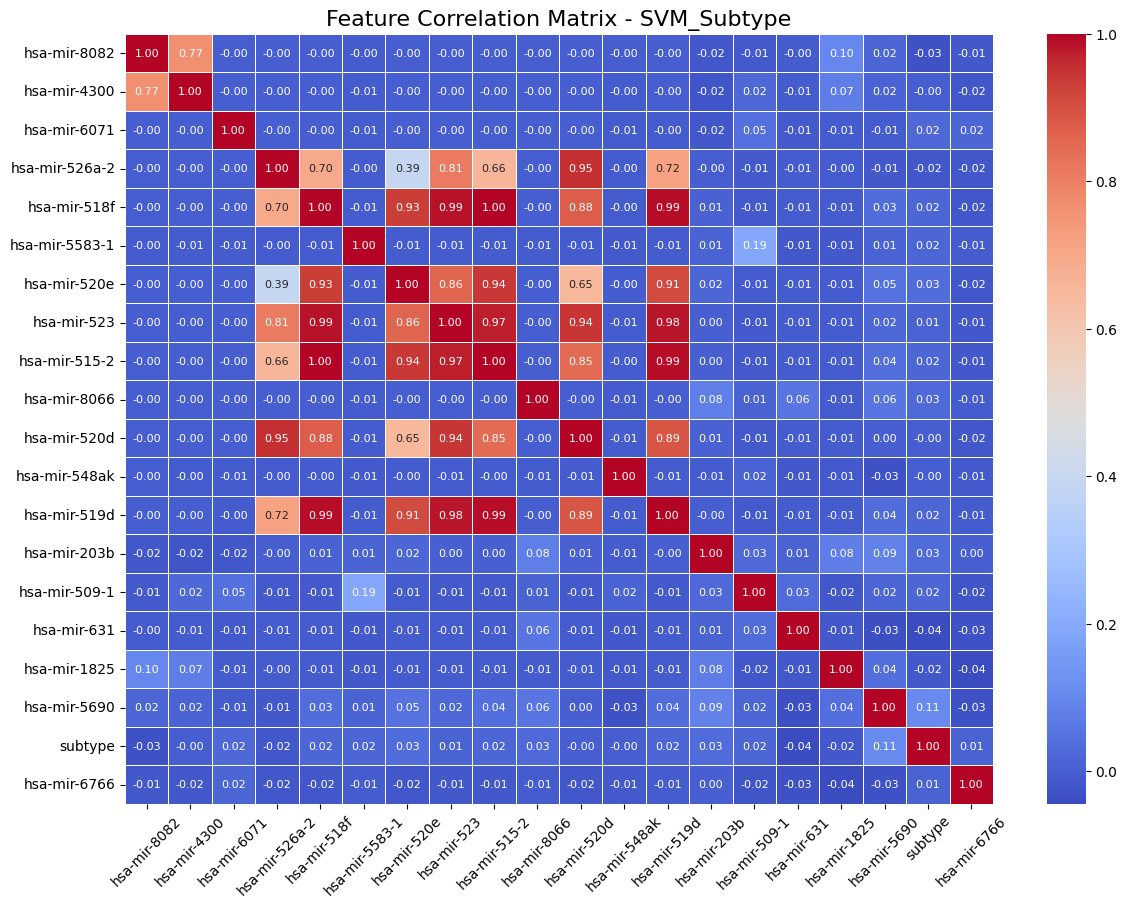


Covariance matrix saved to ../results/svm/svm_subtype_covariance_matrix.png


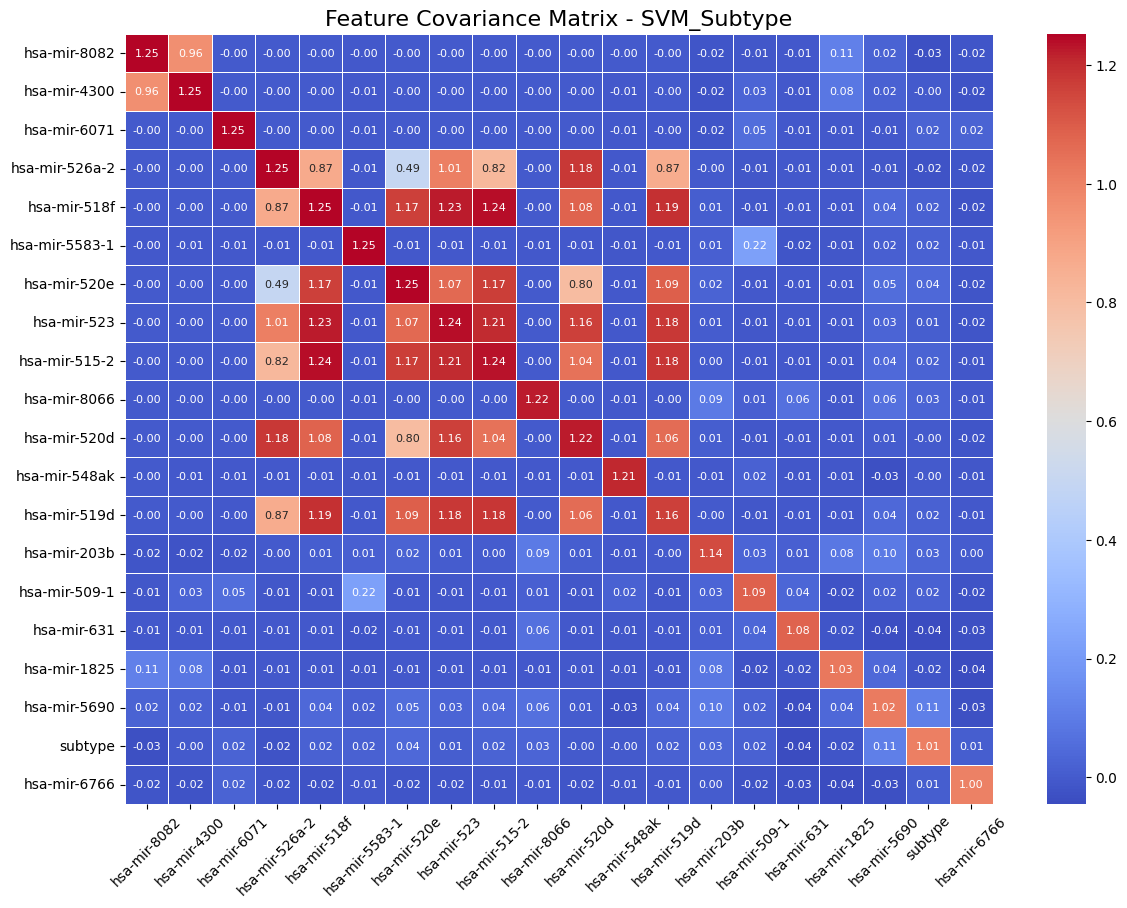


Top 10 Features Based on Maximum Variance:
['hsa-mir-8082', 'hsa-mir-4300', 'hsa-mir-6071', 'hsa-mir-526a-2', 'hsa-mir-518f', 'hsa-mir-5583-1', 'hsa-mir-520e', 'hsa-mir-523', 'hsa-mir-515-2', 'hsa-mir-8066']

Top features saved to ../results/svm/svm_subtype_top_features.txt


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
import pandas as pd

# Logging Setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def evaluate_model(y_test, y_pred, X_train, model_name, save_dir="../results/svm/"):
    """
    Evaluate model performance with accuracy, sensitivity, specificity, and confusion matrices.
    Also computes correlation and covariance matrices.
    
    Args:
        y_test (array-like): True labels.
        y_pred (array-like): Predicted labels.
        X_train (DataFrame): Training feature set (used for correlation and covariance).
        model_name (str): Name of the model being evaluated.
        save_dir (str): Directory to save evaluation results.
    
    Returns:
        dict: Contains accuracy, sensitivity, specificity, confusion matrix, and feature importance.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

    # Compute Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Compute Sensitivity (Recall) & Specificity
    if cm.shape == (2, 2):  # Binary classification case
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    else:  # Multiclass case (Generalized Macro Recall)
        sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=1))  # Macro-average recall
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=0))  # Macro-average specificity

    # Print Evaluation Results
    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("\nConfusion Matrix:\n", cm)

    # Classification Report
    report = classification_report(y_test, y_pred, zero_division=0)
    print("\nClassification Report:\n", report)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')

    # Save Confusion Matrix Plot
    cm_path = os.path.join(save_dir, f"{model_name.lower()}_confusion_matrix.png")
    plt.savefig(cm_path)
    print(f"\nConfusion matrix saved to {cm_path}")
    plt.show()

    # Log Evaluation Metrics
    logging.info(f"\nModel Evaluation Completed for {model_name}!")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"Sensitivity: {sensitivity:.4f}")
    logging.info(f"Specificity: {specificity:.4f}")

    # Select top 20 highest variance features for better visualization
    top_variance_features = X_train.var().sort_values(ascending=False).index[:20]
    
    # Compute & Plot Filtered Correlation Matrix
    filtered_corr_matrix = X_train[top_variance_features].corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(filtered_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",
                linewidths=0.5, annot_kws={"size": 8})  # Smaller text size
    plt.title(f"Feature Correlation Matrix - {model_name}", fontsize=16)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)

    # Save Correlation Matrix
    corr_path = os.path.join(save_dir, f"{model_name.lower()}_correlation_matrix.png")
    plt.savefig(corr_path)
    print(f"\nCorrelation matrix saved to {corr_path}")
    plt.show()

    # Compute & Plot Filtered Covariance Matrix
    filtered_cov_matrix = X_train[top_variance_features].cov()
    plt.figure(figsize=(14, 10))
    sns.heatmap(filtered_cov_matrix, annot=True, cmap="coolwarm", fmt=".2f",
                linewidths=0.5, annot_kws={"size": 8})  # Smaller text size
    plt.title(f"Feature Covariance Matrix - {model_name}", fontsize=16)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)

    # Save Covariance Matrix
    cov_path = os.path.join(save_dir, f"{model_name.lower()}_covariance_matrix.png")
    plt.savefig(cov_path)
    print(f"\nCovariance matrix saved to {cov_path}")
    plt.show()

    # Identify Top 10 Features Based on Variance
    feature_variance = X_train.var().sort_values(ascending=False)
    top_10_features = feature_variance.index[:10].tolist()
    print("\nTop 10 Features Based on Maximum Variance:")
    print(top_10_features)

    # Save Top Features to File
    top_features_path = os.path.join(save_dir, f"{model_name.lower()}_top_features.txt")
    with open(top_features_path, "w") as f:
        for feature in top_10_features:
            f.write(feature + "\n")
    print(f"\nTop features saved to {top_features_path}")

    return {
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "confusion_matrix": cm.tolist(),
        "classification_report": report,
        "top_10_features": top_10_features
    }

# Evaluate Each Model (Including Feature Set for Analysis)
metrics_diagnosis = evaluate_model(y_test_diagnosis, y_pred_diagnosis, X_train, model_name="SVM_Diagnosis")
metrics_stage = evaluate_model(y_test_stage, y_pred_stage, X_train, model_name="SVM_Stage")
metrics_subtype = evaluate_model(y_test_subtype, y_pred_subtype, X_train, model_name="SVM_Subtype")

### Save Everything & Finalize the Pipeline

In [9]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory
output_dir = "../results/svm/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Save Predictions & Actual Labels
predictions = {
    "Diagnosis": (y_test_diagnosis, y_pred_diagnosis, "svm_predictions_diagnosis.csv"),
    "Stage": (y_test_stage, y_pred_stage, "svm_predictions_stage.csv"),
    "Subtype": (y_test_subtype, y_pred_subtype, "svm_predictions_subtype.csv"),
}

for label, (y_test, y_pred, filename) in predictions.items():
    pred_path = os.path.join(output_dir, filename)
    pd.DataFrame({"actual": y_test, "predicted": y_pred}).to_csv(pred_path, index=False)
    logging.info(f"{label} predictions saved to {pred_path}")

# Save Experiment Metadata
metadata = {
    "diagnosis_hyperparameters": metrics_diagnosis["classification_report"],
    "stage_hyperparameters": metrics_stage["classification_report"],
    "subtype_hyperparameters": metrics_subtype["classification_report"],
    "diagnosis_accuracy": metrics_diagnosis["accuracy"],
    "stage_accuracy": metrics_stage["accuracy"],
    "subtype_accuracy": metrics_subtype["accuracy"],
    "sensitivity_diagnosis": metrics_diagnosis["sensitivity"],
    "sensitivity_stage": metrics_stage["sensitivity"],
    "sensitivity_subtype": metrics_subtype["sensitivity"],
    "specificity_diagnosis": metrics_diagnosis["specificity"],
    "specificity_stage": metrics_stage["specificity"],
    "specificity_subtype": metrics_subtype["specificity"],
    "top_10_features_diagnosis": metrics_diagnosis["top_10_features"],
    "top_10_features_stage": metrics_stage["top_10_features"],
    "top_10_features_subtype": metrics_subtype["top_10_features"],
    "train_size": X_train.shape[0],
    "test_size": X_test.shape[0],
}

metadata_path = os.path.join(output_dir, "svm_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")

# Save Trained Models
models = {
    "Diagnosis": (best_estimators["Diagnosis"], "svm_model_diagnosis.pkl"),
    "Stage": (best_estimators["Stage"], "svm_model_stage.pkl"),
    "Subtype": (best_estimators["Subtype"], "svm_model_subtype.pkl"),
}

for label, (model, filename) in models.items():
    model_path = os.path.join(output_dir, filename)
    if model:
        joblib.dump(model, model_path)
        logging.info(f"{label} model saved to {model_path}")
    else:
        logging.warning(f"{label} model was not found and was not saved.")

# Log File Paths
logging.info(f"All results successfully saved in {output_dir}")
print("\nAll results successfully saved. The SVM pipeline is complete!")

2025-02-26 16:25:19,633 - INFO - Diagnosis predictions saved to ../results/svm/svm_predictions_diagnosis.csv
2025-02-26 16:25:19,635 - INFO - Stage predictions saved to ../results/svm/svm_predictions_stage.csv
2025-02-26 16:25:19,637 - INFO - Subtype predictions saved to ../results/svm/svm_predictions_subtype.csv
2025-02-26 16:25:19,638 - INFO - Metadata saved to ../results/svm/svm_metadata.json
2025-02-26 16:25:19,643 - INFO - Diagnosis model saved to ../results/svm/svm_model_diagnosis.pkl
2025-02-26 16:25:19,647 - INFO - Stage model saved to ../results/svm/svm_model_stage.pkl
2025-02-26 16:25:19,650 - INFO - Subtype model saved to ../results/svm/svm_model_subtype.pkl
2025-02-26 16:25:19,650 - INFO - All results successfully saved in ../results/svm/



All results successfully saved. The SVM pipeline is complete!
